## 7.7 稠密连接网络(DenseNet)

ResNet极大地改变了如何参数化深层网络中函数的观点。稠密连接网络(DenseNet)在某种程度上是ResNet的逻辑拓展。

### 7.7.1 从ResNet到DenseNet
回想一下任意函数的泰勒展开式(Taylor expansion)，它把这个函数分解成越来越高阶的项。在x接近0时，
$$
f(x) = f(0) + f'(0)x + \frac {f''(0)}{2!} x^2 + \frac{f'''(0)}{3!} +...
$$

同样，ResNet将函数展开为
$$
f(x) = x + g(x)
$$

也就是说，ResNet将f分解为两部分：一个简单的线性和一个复杂的非线性项。那么再向前拓展一步，如果我们想将f拓展成超过两部分的信息呢？一种方案便是DenseNet。

<div align=center>
<img src='../../pics/7_7_1.jpeg' width='50%'>
</div>

如图7.7.1所示，ResNet和DenseNet的关键区别在于，DenseNet输出是连接(用图中的[,]表示)而不是如ResNet的简单相加。因此，在应用越来越复杂的函数序列后，我们执行从x到其展开式的映射：
$$
x \leftarrow [x, f_1 (x), f_2 ([x, f_1 (x)]), f_3 ([x, f_1 (x), f_2 ([x, f_1 (x)])]), ...]
$$

最后，将这些展开式结合到多层感知机中，再次减少特征的数量。实现起来非常简单：我们不需要添加术语，而是将他们连接起来。DenseNet这个名字由变量之间的“稠密连接”而得来，最后一层与之前的所有层紧密相连。稠密连接如图7.7.2所示。

<div align=center>
<img src='../../pics/7_7_2.jpeg' width='50%'>
</div>

稠密网络主要由2部分构成：稠密块(dense block)和过渡层(transmit layer)。前者定义如何连接输入和输出，而后者则控制通道数量，使其不会太复杂。

### 7.7.2 稠密块体
DenseNet使用ResNet改良版的“批量规范化、激活和卷积”架构。我们首先实现一下这个架构

In [4]:
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

一个稠密块由多个卷积块组成，每个卷积块使用相同数量的输出通道。然而，在前向传播中，我们将每个卷积块的输入和输出在通道维上连结。

In [5]:
class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super(DenseBlock, self).__init__()
        layer = []
        for i in range(num_convs):
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels))

        self.net = nn.Sequential(*layer)

    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X

在下面的例子中，我们定义一个有2个输出通道数为10的DenseBlock。使用通道数为3的输入时，我们会得到通道数为$3 + 2 \times 10 = 23$的输出。卷积块的通道数控制了输出通道数相对于输入通道数的增长，因此也被称为增长率(growth rate)。

In [6]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

### 7.7.3 过渡层
由于每个稠密块都会带来通道数的增加，使用过多则会过于复杂化模型。而过渡层可以用来控制模型复杂度。它通过$1 \times 1$卷积层来减小通道数，并使用步幅为2的平均汇聚层减半高和宽，从而进一步降低模型复杂度。

In [7]:
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1),
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

对上一个例子中稠密块的输出使用通道数为10的过渡层。此时输出的通道数减10，高和宽均减半。

In [8]:
blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

### 7.7.4 DenseNet模型
我们来构造DenseNet模型。DenseNet首先使用同ResNet一样的单卷积层和最大汇聚层


In [9]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

接下来，类似于ResNet使用的4个残差块，DenseNet使用的是4个稠密块。与ResNet类似，我们可以设置每个稠密块使用多少个卷积层。这里我们设成4，从而与7.6节的ResNet-18保持一致。稠密块里的卷积层通道数(增长率)设为32，所以每个稠密块增加128个通道

在每个模块之间，ResNet通过步幅为2的残差块较小高和宽，DenseNet则使用过渡层来减半高和宽，并减半通道数。

In [10]:
# num_channels为当前的通道数
num_channels, growth_rate = 64, 32
num_convs_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_convs_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个稠密块的输出通道数
    num_channels += num_convs * growth_rate
    # 在稠密块之间添加一个转换层，使通道数量减半
    if i != len(num_convs_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

与ResNet类似，最后接上全局汇聚层和全连接层来输出结果。

In [11]:
net = nn.Sequential(
    b1, *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

### 7.7.5 训练模型

loss 0.140, train acc 0.949, test acc 0.801
1939.3 examples/sec on cuda:0


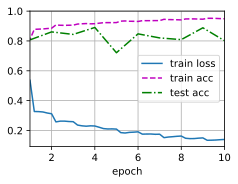

In [12]:
lr, num_epochs, batch_size = 0.1, 10, 256
train, test = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train, test, num_epochs, lr, d2l.try_gpu())

### 7.7.6 小结
- 在跨层连接上，不同于ResNet中将输入与输出相加，稠密连接网络(DenseNet)在通道维上连结输入与输出
- DenseNet的主要构建模块是稠密块和过渡层
- 在构建DenseNet时，我们需要通过添加过渡层来控制网络的维数，从而再次减少通道的数量